# Optimizing neurally diverse architectures for small and imbalanced subsets of MNIST  

* This notebook is for exploring architectural specifications for neurally diverse architectures on a small and imbalanced version of MNIST.
* The architecture includes pre-branch, branch, and post-branch segments. Neural diversity is implemented specifically at the level of activation function non-linearity and a small wet of "connection functions" (i.e. linear, identity, and element-wise scaling).
* A highly simplistic form of architectural search based on stochastic hill-climbing with some differential search is included, for your reference.
* 0.3.7 - added id and elementwise scaling weight functions.
* 0.3.8 - added training acuracies; do_train is now returning the model with the best validation error.
* 0.3.9 - added basic DropCircuit.

In [0]:
version = '_v0p3p9_'

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import torch
import numpy as np
from torch.utils import data
import copy

from __future__ import print_function
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from IPython.core.debugger import set_trace

# ===============
# Initializations
# ===============

!pip install torch torchvision

# ===============
# Parameters
# ===============

# --- General framework arguments

args = {}
kwargs = {}
args['num_train_batch'] = 1  # number of MNIST training batches
args['num_valid_batch'] = 10  # number of MNIST validation batches
args['train_batch_size'] = 100   # training batch size
args['valid_batch_size'] = 100   # validation batch size
args['test_batch_size'] = 10
# args['epochs'] = 100  # number of training epochs 
args['lr'] = 1 # 0.1  # 0.01 # learning rate # this is over-written by the solution
args['momentum'] = 0.5 # SGD momentum (default: 0.5); momentum is a moving average of our gradients (helps keep a useful direction)
args['clip_level'] = 0.5  # gradient clip threshold
args['seed']= 1 #random seed
args['log_interval_epoch'] = 1 # display training loss every log_int... epochs
args['cuda'] = True 
args['patience'] = 1000  # stop train. if the valid. err. hasn't improved by this num. of epochs
args['noise_in'] = -1   # 0.5  # 0.15  # amount of noise to add to the training data
args['noise_out'] = -1   #  probability of changing an output label to some random label
args['verbose_train'] = False   # print status of model training?
args['verbose_meta'] = True #  print status of architecture optimization?
args['min_inst_class'] = 5 # minimum number of instances per class in the training set
args['batch_max_tries'] = 10 # max. num. of attempts in extracting data batches
args['save_best_chrom'] = False # False  # save the best chromose in Google Drive?
args['dc_prob_drop'] = 0.5 # 0.5 # probability of dropping a circuit (DropCircuit)
args['prob_sel_branch'] = 0.5 # probability of architectural search selecting/using a branch (this is not DropCircuit) 

# --- Neural architectural limits

args['num_epochs_search'] = 10 # 100  # number of epochs for training during architecture search 
args['num_epochs_test'] = 1000  # num. epochs for training during the final test
limits = {}
limits['min_layer_nodes'] =  10 # 5 # 50
limits['max_layer_nodes'] = 100
limits['max_pre_branch_layers'] = 5 # 3
limits['max_branches'] = 10
limits['max_branch_layers'] = 5  # 3
limits['max_post_branch_layers'] = 5 # 3
limits['lr1_min'] = 0.001
limits['lr1_,max'] = 2
limits['lr2_min'] = 0.001
limits['lr2_,max'] = 2
limits['moment_min'] = 0.001
limits['moment_max'] = 1

# np.random.seed(0)
# torch.manual_seed(0)

num_train_instances = args['num_train_batch'] * args['train_batch_size']
num_valid_instances = args['num_valid_batch'] * args['valid_batch_size']

data_rand_seed = 1 # (other pre-tested seeds: 2, 3)

# ============
# Load dataset
# ============

# Seed creation
torch.manual_seed(data_rand_seed)
np.random.seed(data_rand_seed)

a_data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=a_data_transform),
    batch_size=args['train_batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=a_data_transform),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

# Check whether we have enough instances per class
# We want an imbalanced dataset but we don't want any specific label having
# an "insufficient" number of instances.
def check_enough_inst(batches, min_inst_per_class):
  
  # Concatenate training batch output labels
  labels = batches[0][1].numpy()
  for batch_i in range(1,args['num_train_batch']):
    new_labels = batches[batch_i][1].numpy()
    labels = np.concatenate((labels, new_labels))

  labels = labels.tolist()

  # Scan though labels
  for a_label in range(10):  # assuming MNIST, of course
    a_count = labels.count(a_label)
    # If label count is < min_inst_per_class return False
    if a_count < min_inst_per_class:
      return False

  # Return True
  return True


# Prepare data. Extract training and validation batches
# This is where we make the problem "small and imbalanced"
def extract_batches(a_loader, min_inst_per_class, max_tries):

  # Keep trying until you have a required minimum number of instances 
  # per class in the training set (not elegant but ok for the range of 
  # "min_inst_per_class" we need)

  for ti in range(max_tries):

    print('Data extraction trial {}.'.format(ti))

    # Initializations
    train_batches = []
    valid_batches = []
    tot_batch_extract = args['num_train_batch'] + args['num_valid_batch']

    # Extract
    for batch_idx, (data, target) in enumerate(a_loader):

      if batch_idx < args['num_train_batch']:
        train_batches.append((data,target))
      else:
        valid_batches.append((data,target))
        if batch_idx == tot_batch_extract - 1:
          break

    # Check minimum number of instances
    enough_instaces = check_enough_inst(train_batches, min_inst_per_class)
    if enough_instaces:
      return train_batches, valid_batches

  print('It was not possible to create a dataset.')
  print('Consider increasing the overall number of instances, or')
  print('decreasing the minimum instances per class allowed.')
  return [], []


train_batches, valid_batches = extract_batches(train_loader, args['min_inst_class'], args['batch_max_tries'])
if args['verbose_train']:
  print('Extracted {} train_batches, and {} valid_batches.'.format(len(train_batches), len(valid_batches)))

# ===========================
# Display histogram of labels
# ===========================

def disp_hist_labaels(batches):
  # Concatenate training batch output labels
  labels = batches[0][1].numpy()
  for batch_i in range(1,args['num_train_batch']):
    new_labels = batches[batch_i][1].numpy()
    labels = np.concatenate((labels, new_labels))

  num_bins = 10
  n, bins, patches = plt.hist(labels, num_bins, facecolor='blue', alpha=0.5)
  plt.show()

disp_hist_labaels(train_batches)

# ==========================
# Display dataset
# ==========================

# This is not currently used

# Display MNIST instances
# Adapted from # https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb
def disp_MNIST_inst(num_disp, X_train, y_train):
  pltsize=1
  plt.figure(figsize=(num_disp*pltsize, pltsize))
  for i in range(num_disp):
    plt.subplot(1,num_disp,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

if args['verbose_train']:
  X_train = train_batches[0][0]
  y_train = train_batches[0][1]

  disp_MNIST_inst(10, X_train, y_train)

  sum_train_0 = X_train[0,:,:].sum()
  min_train_0 = X_train[0,:,:].min()
  max_train_0 = X_train[0,:,:].max()

  print('X_train[0,:,:] --> sum ({}); min ({}); max ({}).'.format(sum_train_0, min_train_0, max_train_0))

# ==========================
# Design model
# ==========================

# "Unseed" the rest
np.random.seed()
a_rand_seed = np.random.randint(0,999999)
torch.manual_seed(a_rand_seed)

# Simple function to scale parameters
# num is assume to be \in [0,1]
def scale_to_range(num,min_val,max_val):
  range = max_val - min_val
  return (num*range)+min_val

# Simple layer for doing elementwise scaling
# Adapated from https://stackoverflow.com/questions/51980654/pytorch-element-wise-filter-layer
class Elem_Scaling_1D(nn.Module):
  def __init__(self, num_nodes, bogus):  # clean-up "bogus"
    super(Elem_Scaling_1D, self).__init__()
    # Initialize
    init_weights = np.random.normal(loc=0, scale=0.5, size=np.shape(num_nodes))
    # Assign
    self.weights = torch.from_numpy(init_weights)
    #self.weights = nn.Parameter(torch.Tensor(1, num_nodes))  # trainable parameter

  def forward(self, x):
    # assuming x is of size num_inst-1-num_nodes
    return x * self.weights  # element-wise multiplication

# Class gradient-based neural diversity machine
class GBNDM(nn.Module):   
    def __init__(self, a_chromosome):   # assuming MNIST
        super(GBNDM, self).__init__()

        # --------- Pre-branch layers 
        self.chromosome = a_chromosome
        self.pre_branch_layers = nn.ModuleList()
        prev_num_out = 28*28
        chrom_ind = 5 # skip over 3 learning rate param., 1 moment. p. (interp./used in training)
        # and 1 exist-or-not (may use in future versions).
        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for i in range(limits['max_pre_branch_layers']):
          
          # Extract and interpret parameters
          layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
          layer_params_real = self.interp_layer_param(layer_params_raw)
        
          # Decide on whether to create a layer or not
          if i==0:  # the first layer of each segment is done by default
            do_layer = True
          else:
            do_layer = layer_params_real[0]

          if do_layer:
            # Create layer    
            a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
            # Append layer and update chromosome index
            self.pre_branch_layers.append(a_layer)
            
          chrom_ind += 6

        # --------- Branches
        num_out_pre_branch = prev_num_out

        self.branches = nn.ModuleList()

        # Scan over branches
        final_num_nodes = []  # keep track of the size of the final layer of each branch
        count_branches = 0
        for bi in range(limits['max_branches']):

          # Initialize branch
          branch_layers = nn.ModuleList()

          # Do branch? Always do the first one by default
          if (a_chromosome[chrom_ind] < args['prob_sel_branch']) or (bi == 0):
            do_branch = True
          else: 
            do_branch = False
            
          chrom_ind += 1

          # Scan over branch layers

          if do_branch:  # if doing branch

            this_fin_num_nodes = 0

            count_branches += 1
            
            for li in range(limits['max_branch_layers']):

              # Extract and interpret parameters
              layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
              layer_params_real = self.interp_layer_param(layer_params_raw)

              # Decide on whether to create a layer or not
              if li==0:  # the first layer of each branch is done by default
                do_layer = True
                prev_num_out = num_out_pre_branch
              else:
                do_layer = layer_params_real[0]

              if do_layer:
                # print('... temp ... this_fin_num_nodes: {}.'.format(this_fin_num_nodes))
                # Create layer    
                a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
                # Num_nodes - keep storing the latest one; the last latest is the final layer num_nodes
                this_fin_num_nodes = prev_num_out
                # Append layer and update chromosome index
                branch_layers.append(a_layer)

              chrom_ind += 6

            # Append branch
            final_num_nodes.append(this_fin_num_nodes)
            #print('final_num_nodes: {}.'.format(final_num_nodes))
            self.branches.append(branch_layers)

          else: # if not doing branch you still need to increment chromosome index

            chrom_ind += 6*limits['max_branch_layers']

        self.num_branches = count_branches
        self.dc_prob_activ = 1 - args['dc_prob_drop'] # probability of using a circuit
        self.tot_nodes_branch_final = sum(final_num_nodes)
        
        # --------- Post-branch layers

        prev_num_out = self.tot_nodes_branch_final
        
        # --- Create post-branch layers

        chrom_ind += 1  # skip over the parameter pertaining to the existence or not of the post-branch segment

        self.post_branch_layers = nn.ModuleList()
        
        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for li in range(limits['max_post_branch_layers']):
          
          # Extract and interpret parameters
          layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
          layer_params_real = self.interp_layer_param(layer_params_raw)
        
          # Decide on whether to create a layer or not
          if li==0:  # the first layer of each segment is done by default
            do_layer = True
          else:
            do_layer = layer_params_real[0]

          if do_layer:
            # Create layer    
            a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
            # Append layer and update chromosome index
            self.post_branch_layers.append(a_layer)
            
          chrom_ind += 6

        # Create a final layer
        self.final_layer = nn.Linear(prev_num_out, 10)

    def forward(self, x, dc_mask = None):
        
        x = x.view(-1, 28*28)

        # Apply pre-branch layers
        for pi, a_layer in enumerate(self.pre_branch_layers):
          #print('Pre-layer {}'.format(pi))
          # if isinstance(a_layer, Elem_Scaling_1D):
          #   set_trace()
          x = a_layer(x)

        # Apply branches
        branch_finals = []
        for bi, a_branch in enumerate(self.branches):
          #print('Branch {}'.format(bi))
          
          z = x

          for a_layer in a_branch:
            # if isinstance(a_layer, Elem_Scaling_1D):
            #   set_trace()
            z = a_layer(z)
          
          if self.training:
            z = (dc_mask[bi] * z) / self.dc_prob_activ  # if training apply DropCircuit
          
          branch_finals.append(z)

        # Concatenate multi-branch final layers
        x = torch.cat(branch_finals,dim=1)

        # if not(self.training): # if not training then testing/evaluating
        #   x = self.dc_prob_activ * x  # scaling due to DropCircuit
      

        # Apply post-branch layers
        for pi, a_layer in enumerate(self.post_branch_layers):
          #print('Post-layer: {}'.format(pi))
          # if isinstance(a_layer, Elem_Scaling_1D):
          #   set_trace()
          x = a_layer(x)

        # Apply final layer
        x = self.final_layer(x)
               
        return F.log_softmax(x, dim=1)


    # Method for interpreting layer parameters
    # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
    def interp_layer_param(self, layer_params_raw):
      # Exist or not
      if layer_params_raw[0] < 0.5:
        exist = False
      else:
        exist = True
      # Weight function
      tot_weight_func = 3
      if layer_params_raw[1] < 0.6: # or ... (1/tot_weight_func):  
        weight_func_sel = 'linear'
      elif layer_params_raw[1] < 0.8: # or ... (2/tot_weight_func):
        weight_func_sel = 'elem_scale'
      else:
        weight_func_sel = 'id'
      # activation function
      tot_node_func = 22
      if layer_params_raw[2] < (1/tot_node_func):
        activ_func = 'ReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (2/tot_node_func):
        activ_func = 'Hardshrink'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (3/tot_node_func):
        activ_func = 'Hardtanh'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,2)
        if param_1 > param_2:  # param_1 is min_val; param_2 is max_val
          tmp_val = param_1
          param_1 = param_2
          param_2 = tmp_val
        elif param_1 == param_2:
          param_2 += 0.1
      elif layer_params_raw[2] < (4/tot_node_func):
        activ_func = 'LeakyReLU'
        param_1 = scale_to_range(layer_params_raw[3],0,1)
        param_2 = -1
      elif layer_params_raw[2] < (5/tot_node_func):
        activ_func = 'LogSigmoid'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (6/tot_node_func):
        activ_func = 'PReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (7/tot_node_func):
        activ_func = 'ELU'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (8/tot_node_func):
        activ_func = 'ReLU6'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (9/tot_node_func):
        activ_func = 'RReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (10/tot_node_func):
        activ_func = 'SELU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (11/tot_node_func):
        activ_func = 'CELU'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (12/tot_node_func):
        activ_func = 'GELU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (13/tot_node_func):
        activ_func = 'Sigmoid'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (14/tot_node_func):
        activ_func = 'Softplus'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,40)
      elif layer_params_raw[2] < (15/tot_node_func):
        activ_func = 'Softshrink'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (16/tot_node_func):
        activ_func = 'Softsign'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (17/tot_node_func):
        activ_func = 'Tanh'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (18/tot_node_func):
        activ_func = 'Tanhshrink'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (19/tot_node_func):
        activ_func = 'Threshold'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,2)
      elif layer_params_raw[2] < (20/tot_node_func):
        activ_func = 'Softmin'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (21/tot_node_func):
        activ_func = 'Softmax'
        param_1 = -1
        param_2 = -1
      else: 
        activ_func = 'None'
        param_1 = -1
        param_2 = -1

      # number of nodes
      num_nodes = scale_to_range(layer_params_raw[5], limits['min_layer_nodes'], limits['max_layer_nodes'])
      num_nodes = num_nodes.astype(int)

      return (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)

    # Method for creating a layer
    # layer_params_real format: (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)
    def create_layer(self, prev_num_out, layer_params_real):
      
      exist, weight_func_sel, activ_func, param_1, param_2, num_nodes = layer_params_real
      
      # wf_param1/wf_param2 --> not elegant 
      if weight_func_sel == 'linear':
        weight_func = nn.Linear
        num_nodes_in = prev_num_out
        num_nodes_out = num_nodes
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
      elif weight_func_sel == 'id':
        weight_func = nn.Identity
        num_nodes_in = prev_num_out
        num_nodes_out = prev_num_out
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
      else:  # 'elem_scale'
        weight_func = Elem_Scaling_1D
        num_nodes_in = prev_num_out
        num_nodes_out = prev_num_out
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
        
      if activ_func == 'ReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU())
      elif activ_func == 'Hardshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Hardshrink(param_1))
      elif activ_func == 'Hardtanh':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Hardtanh(param_1, param_2))
      elif activ_func == 'LeakyReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.LeakyReLU(param_1))
      elif activ_func == 'LogSigmoid':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.LogSigmoid())
      elif activ_func == 'PReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.PReLU())
      elif activ_func == 'ELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ELU(param_1))
      elif activ_func == 'ReLU6':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU6())
      elif activ_func == 'RReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.RReLU())
      elif activ_func == 'SELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.SELU())
      elif activ_func == 'CELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.CELU(param_1))
      elif activ_func == 'GELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU())  # for some reason GELU is not present; revert later if relevant
      elif activ_func == 'Sigmoid':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Sigmoid())
      elif activ_func == 'Softplus':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softplus(param_1, param_2))
      elif activ_func == 'Softshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softplus(param_1))
      elif activ_func == 'Softsign':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softsign())
      elif activ_func == 'Tanh':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Tanh())
      elif activ_func == 'Tanhshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Tanhshrink())
      elif activ_func == 'Threshold':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Threshold(param_1, param_2))
      elif activ_func == 'Softmin':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softmin())
      elif activ_func == 'Softmax':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softmax())
      else:
        a_layer = weight_func(wf_param1, wf_param2)

      return a_layer, num_nodes_out


# Generate a random chromosome where each param. is \in [0,1)
def gen_rand_chromosome(num_param):
  chrom = np.random.rand(num_param)
  return chrom

# ==========================
# Train and test functions
# ==========================

# Create a random mask for DropCircuit
def make_mask(num_circuits, prob_drop):
  rand_vals = np.random.rand(num_circuits)
  decisions = rand_vals >= prob_drop
  a_mask = np.ones(num_circuits)*decisions
  # Must have at least one circuit active
  if np.sum(a_mask) == 0:
    rand_index = np.random.randint(num_circuits)
    a_mask[rand_index] = 1.0

  return torch.from_numpy(a_mask)

def train_one_epoch(a_model, optimizer, epoch, batches):

  a_model.train()
  for batch_idx, (data, target) in enumerate(batches):
      if args['cuda']:
          data, target = data.cuda(), target.cuda()
      # Variables in Pytorch are differentiable. 
      
      data, target = Variable(data), Variable(target)
      #This will zero out the gradients for this batch. 
      optimizer.zero_grad()
      
      # Create DropCircuit mask
      dc_mask = make_mask(a_model.num_branches, args['dc_prob_drop'])
      
      output = a_model(data, dc_mask)

      # Calculate the negative log likelihood loss.
      loss = F.nll_loss(output, target)
      #dloss/dx for every Variable 
      loss.backward()
      # Gradient clipping
      torch.nn.utils.clip_grad_norm_(a_model.parameters(), args['clip_level'])
      #to do a one-step update on our parameter.
      optimizer.step()
      #Print out the loss periodically. 

  if args['verbose_train']:
    if epoch % args['log_interval_epoch'] == 0:
      print('Epoch: {}. Latest loss: {}.'.format(epoch, loss.data))

# Compute accuracy
# The argument (data_source) of this function can be a data_loader or a list of batches (previously extracted) 
def comp_accuracy(a_model, data_source, src_num_instances):
    a_model.eval()
    a_loss = 0
    correct = 0
    preds = torch.zeros(0)
    first = True
    for a_data_in, a_data_out in data_source:
        if args['cuda']:
            a_data_in, a_data_out = a_data_in.cuda(), a_data_out.cuda()
        a_data_in, a_data_out = Variable(a_data_in), Variable(a_data_out)
        output = a_model(a_data_in)

        a_loss += F.nll_loss(output, a_data_out, reduction='sum').data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        if first:
          preds = pred
          first = False
        else:
          preds = torch.cat((preds, pred),0)

        correct += pred.eq(a_data_out.data.view_as(pred)).long().cpu().sum()

    # Compute and return accuracy
    if type(data_source) == list:  # case: list of batches
      result = 100. * (correct.numpy()/ src_num_instances)
    else: # case: data_loader
      result = 100. * (correct.numpy()/ len(data_source.dataset))
    return result



# ==========================
# Train and test functions
# ==========================
# Compute the number of parameters in a chromose (depends on limits)
def comp_num_chrom_param(limits):
  # Num. of training parameters
  tot_train_param = 4 # lr1, lr2, lr2 prop, momentum
  # Num. of pre-branch parameters
  tot_pre_branch = 1+(6*limits['max_pre_branch_layers']) # exist-or-not, layer params.
  # Num. of branch parameters
  tot_branch = (1+(6*limits['max_branch_layers']))*limits['max_branches']
  # Num. of post-branch parameters
  tot_post_branch = 1+(6*limits['max_post_branch_layers'])

  return tot_train_param+tot_pre_branch+tot_branch+tot_post_branch

# Interpret learning rate and momentum parameters
def interp_lrm(params):
  lr1 = scale_to_range(params[0], limits['lr1_min'], limits['lr1_,max'])
  lr2 = scale_to_range(params[1], limits['lr2_min'], limits['lr2_,max'])
  if lr1 < lr2:
    temp = lr1
    lr1 = lr2
    lr2 = temp
  lr2_epoch = (np.round(params[2]*args['num_epochs_search'])).astype(int)
  a_decr = (lr1-lr2)/lr2_epoch
  a_momentum = scale_to_range(params[3], limits['moment_min'], limits['moment_max'])
  return lr1, lr2, lr2_epoch, a_momentum, a_decr

# Chromosome evaluation (more efficient than do_training)
# Function to train a specific model
# Early stopping, or returning best validation model, is not implemented 
def do_eval_chrom(a_model, train_params, num_epochs):
  global counter
  counter += 1
  # Extract basic information
  lr1, lr2, lr2_epoch, a_momentum, lr_decr = train_params  
  args['lr'] = lr1
  args['momentum'] = a_momentum
  
  optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
  valid_accurs = []
  train_accurs = []
  train_start_time = time.time()
  for epoch in range(1, num_epochs + 1):

    if args['verbose_train']:
      print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

    train_one_epoch(a_model, optimizer, epoch, train_batches)
    
    a_train_accur = comp_accuracy(a_model, train_batches, num_train_instances)
    if args['verbose_train']:
      print('Training accuracy: {}%.'.format(a_train_accur))
    train_accurs.append(a_train_accur)
    
    a_valid_accur = comp_accuracy(a_model, valid_batches, num_valid_instances)
    if args['verbose_train']:
      print('Validation accuracy: {}%.'.format(a_valid_accur))
    valid_accurs.append(a_valid_accur)

    # Decrement learning rate
    if epoch < lr2_epoch:
        args['lr'] -= lr_decr
        for param_group in optimizer.param_groups:
          param_group['lr'] = args['lr']

  train_elapsed_time = time.time() - train_start_time
  print('The training process took {} seconds.'.format(train_elapsed_time))

  return a_model, valid_accurs, train_accurs

# Function to train a specific model
# Early stopping, or returning best validation model, is not implemented 
def do_training(a_model, train_params, num_epochs):

  lr1, lr2, lr2_epoch, a_momentum, lr_decr = train_params  
  args['lr'] = lr1
  args['momentum'] = a_momentum

  optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
  best_valid_accur = 0
  best_model = type(a_model)(a_model.chromosome) # get a new instance
  valid_accurs = []
  train_accurs = []
  train_start_time = time.time()
  for epoch in range(1, num_epochs + 1):

    if args['verbose_train']:
      print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

    train_one_epoch(a_model, optimizer, epoch, train_batches)
    
    a_train_accur = comp_accuracy(a_model, train_batches, num_train_instances)
    if args['verbose_train']:
      print('Training accuracy: {}%.'.format(a_train_accur))
    train_accurs.append(a_train_accur)
    
    a_valid_accur = comp_accuracy(a_model, valid_batches, num_valid_instances)
    if args['verbose_train']:
      print('Validation accuracy: {}%.'.format(a_valid_accur))
    valid_accurs.append(a_valid_accur)
    if a_valid_accur > best_valid_accur:
      best_valid_accur = a_valid_accur
      # best_model.load_state_dict(a_model.state_dict()) # copy weights and stuff
      best_model = copy.deepcopy(a_model)

    # Decrement learning rate
    if epoch < lr2_epoch:
        args['lr'] -= lr_decr
        for param_group in optimizer.param_groups:
          param_group['lr'] = args['lr']

  train_elapsed_time = time.time() - train_start_time
  print('The training process took {} seconds.'.format(train_elapsed_time))

  if args['cuda']:
      best_model.cuda()

  return a_model, best_model, valid_accurs, train_accurs

# ================================
# Architectureal search
# ================================

# Artificial Intelligence Methods students should focus on the code below.
# You should keep the neural network code unchaged. This is crucial for 
# comparison purposes. In other words, focus only on modifying the architecture
# search code below.

# --- Architectural search parameters
meta = {}
meta['max_rs_iter'] = 10 # 10  # initial random search
meta['max_shc_iter'] = 15 # 40 # 20 # 40  # stochastic hill climbing iterations
meta['num_neighbours'] = 6 # 16 
meta['neighbour_range'] = 0.6  # 0.2  # mutation rate for stochastic hill-climbing
meta['num_differential_sol'] = 6 # 8 # number of differential evolution solutions
meta['diff_lr'] = 0.5 # 0.1 # learning rate for differential search

meta_rs_valids = []
best_model = None
best_chromosome = None
best_model_accur = 0

# Prepare model
def prepare_model(a_rand_chrom):
  # Initialize chromosome and model
  model = GBNDM(a_rand_chrom)
  
  if args['cuda']:
      model.cuda()

  # Interpret learning rates and momentum
  lr1, lr2, lr2_epoch, a_momentum, lr_decr = interp_lrm(a_rand_chrom[0:4])
  train_params = (lr1, lr2, lr2_epoch, a_momentum, lr_decr)
  args['momentum'] = a_momentum
  if args['verbose_train']:
    print('lr1: {}'.format(lr1))
    print('lr2: {}'.format(lr2))
    print('lr2_epoch: {}'.format(lr2_epoch))
    print('a_momentum: {}'.format(a_momentum))
    print('a_decr: {}'.format(a_decr))

  return model, train_params

# Function for creating one neighbour
def create_a_neighbour(a_chromosome, neighbour_range, num_chrom_params):
  # Create mutation vector
  mutat_vec = (np.random.rand(num_chrom_params)*neighbour_range)-(neighbour_range/2)
  # Add mutation vector
  new_chromosome = a_chromosome + mutat_vec
  # Clip
  np.clip(new_chromosome, 0, 0.99999999999, out=new_chromosome)

  return new_chromosome

# Evaluate a list of chromosomes
def eval_chromosomes(list_chromosomes,num_chrom_params):
  
  # best_model_accur, best_chromosome, best_model, best_train_params = best_res
  
  best_model_accur = 0
  best_chromosome = None
  best_model = None
  best_train_params = None


  num_chrom = len(list_chromosomes)
  mat_chrom_acur = np.zeros((num_chrom, 1+num_chrom_params))
  neighb_valid_accurs = []

  for ci, a_chrom in enumerate(list_chromosomes):
    if args['verbose_meta']:
      print('Chromosome {} ...'.format(ci))
    # --- Actual training
    model, train_params = prepare_model(a_chrom)
    model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
    best_valid_accur = max(valid_accurs)
    # Store chromosome and accuracy
    mat_chrom_acur[ci,0] = best_valid_accur
    mat_chrom_acur[ci,1:] = a_chrom
    print('Best validation accuracy: {}%.'.format(best_valid_accur))
    neighb_valid_accurs.append(best_valid_accur)
    if best_valid_accur >= best_model_accur:
      best_model_accur = best_valid_accur
      best_chromosome = a_chrom
      best_model = model
      best_train_params = train_params
      if args['verbose_meta']:
        print('*** Improving validation accuracy: {}.'.format(best_model_accur))

  best_res = (best_model_accur, best_chromosome, best_model, best_train_params)
  return best_res, mat_chrom_acur
      
    
# Function for creating a list of neighbours
def create_neighbours(a_chromosome, meta, num_chrom_params):
  neighbours = []
  
  # Scan through number of neighbours
  for ni in range(meta['num_neighbours']):
    # Create first neighbour
    next_neighb = create_a_neighbour(a_chromosome, meta['neighbour_range'], num_chrom_params)
    # Append neighbour
    neighbours.append(next_neighb)
    a_chromosome = next_neighb

  return neighbours

# Simple differential search
def do_diff_chrom_v1(mat_chrom_accur, num_new_sol):
  
  # Initialize new chromosomes
  num_chrom = mat_chrom_accur.shape[0]
  if num_new_sol >= num_chrom:
    num_new_sol = num_chrom-1
  new_chromosomes = []

  # Sort the array of chromosomes based on the first column (contains accur.)
  mat_chrom_accur = mat_chrom_accur[(-mat_chrom_accur[:,0]).argsort()]
  # Extract first/best chromosome
  best_chrom = mat_chrom_accur[0,1:]
  # Scan through new solutions
  for si in range(num_new_sol):  
    # Extract next best chrom
    # next_best_chrom = mat_chrom_accur[1+si,1:]
    next_best_chrom = mat_chrom_accur[si,1:]
    # Extract worst chrom
    worst_chrom = mat_chrom_accur[num_new_sol-1, 1:]
    # Compute differential
    avg_diff = (best_chrom - worst_chrom)/ num_new_sol
    # Add differential whilst applying a learning rate
    a_new_chrom = best_chrom + (meta['diff_lr']*avg_diff)
    np.clip(a_new_chrom, 0, 0.99999999999, out=a_new_chrom)
    # Store new solution 
    new_chromosomes.append(a_new_chrom)

  return new_chromosomes

def final_test(a_model):
    a_model.eval()
    test_loss = 0
    correct = 0
    test_preds = torch.zeros(0)
    first = True
    for test_data_in, test_data_out in test_loader: 

        if args['cuda']:
            test_data_in, test_data_out = test_data_in.cuda(), test_data_out.cuda()
                
        test_data_in, test_data_out = Variable(test_data_in), Variable(test_data_out)
        output = a_model(test_data_in)
        test_loss += F.nll_loss(output, test_data_out, reduction='sum').data # sum up batch loss

        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        if first:
          test_preds = pred
          first = False
        else:
          test_preds = torch.cat((test_preds, pred),0)

        correct += pred.eq(test_data_out.data.view_as(pred)).long().cpu().sum()

    # Print test accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy (at final epoch): {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return accuracy

accs = []
counter = 0

for i in range(5):
  print("----------------------------------------------------------")
  print(f"Round: {i}")
  print("----------------------------------------------------------")
  best_model_accur = 0
  best_chromosome = None
  best_model = None
  best_train_params = None
  # Start with a small random search
  print('Initital random search ...')
  for rsi in range(meta['max_rs_iter']):

    if args['verbose_meta']:
      print('Search iteration {}.'.format(rsi+1))

    num_chrom_param = comp_num_chrom_param(limits)
    
    a_rand_chrom = gen_rand_chromosome(num_chrom_param)

    # --- Actual training
    model, train_params = prepare_model(a_rand_chrom)
    model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
    best_valid_accur = max(valid_accurs)
    print('Best validation accuracy: {}%.'.format(best_valid_accur))

    # Store best model
    if best_valid_accur > best_model_accur:
      best_model_accur = best_valid_accur
      best_model = model
      best_train_params = train_params
      best_chromosome = a_rand_chrom

    meta_rs_valids.append(best_valid_accur)

  print('*****************************************************')
  print('Best accuracy after initial random search: {}'.format(best_model_accur))
  print('*****************************************************')

  if args['verbose_meta']:
    print('Best validation errors:')
    print(meta_rs_valids)

  # # --- Stochastic hill climbing

  num_chrom_params = best_chromosome.shape[0]





  # Architectural search iterations
  best_res = (best_model_accur, best_chromosome, best_model, best_train_params)

  meta_start_time = time.time()
  for shci in range(meta['max_shc_iter']):

    best_model_accur, best_chromosome, best_model, best_train_params = best_res

    if best_model_accur < 15 and shci == 12:
        best_model_accur = 0
        best_chromosome = None
        best_model = None
        best_train_params = None
        # Start with a small random search
        print('Initital random search ...')
        for rsi in range(12):

          if args['verbose_meta']:
            print('Search iteration {}.'.format(rsi+1))

          num_chrom_param = comp_num_chrom_param(limits)
          
          a_rand_chrom = gen_rand_chromosome(num_chrom_param)

          # --- Actual training
          model, train_params = prepare_model(a_rand_chrom)
          model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
          best_valid_accur = max(valid_accurs)
          print('Best validation accuracy: {}%.'.format(best_valid_accur))

          # Store best model
          if best_valid_accur > best_model_accur:
            best_model_accur = best_valid_accur
            best_model = model
            best_train_params = train_params
            best_chromosome = a_rand_chrom
        
        # print for good measure
        print('-------------------------------------------------------------------------------------')
        print('REINITIALIZED')
        print('-------------------------------------------------------------------------------------')
        break



    if args['verbose_meta']:
      print('======================================')
      print('Stochastic hill-climbing iteration {}.'.format(shci))
      print('======================================')
      print('Best accuracy so far: {}'.format(best_model_accur))
      print('======================================')
    # --- Create a set of stochastic neighbours from the current best model
    chrom_neighbors = create_neighbours(best_chromosome, meta, num_chrom_params)
    # Test validation accuracies of neighbours
    new_res, mat_chrom_acur = eval_chromosomes(chrom_neighbors,num_chrom_params)
    if new_res[0] > best_res[0]:
      best_res = new_res
    print('***********************************************')
    print('Best accuracy after random mutation: {}'.format(new_res[0]))
    print('***********************************************')
    
    # --- Simple differential search
    print('***** Differential Search *********************')
    diff_chromosomes = do_diff_chrom_v1(mat_chrom_acur, meta['num_differential_sol'])
    new_res, mat_chrom_acur = eval_chromosomes(diff_chromosomes,num_chrom_params)
    if new_res[0] > best_res[0]:
      best_res = new_res
    print('***********************************************')
    print('Best accuracy after differential search: {}'.format(new_res[0]))
    print('***********************************************')

  meta_elapsed_time = time.time() - meta_start_time
  if args['verbose_meta']:
    print('=====================================================')
    print('Architectural optimization total time: {}.'.format(meta_elapsed_time))
    print('=====================================================')
    

  # ==========================
  # Test final model / Visualize predictions
  # ==========================



  # Final visualization
  print('======================================')
  print('Best accuracy so far: {}'.format(best_res[0]))
  print('======================================')
  print('Computing the final test ...')
  best_model_accur, best_chromosome, best_model, best_train_params = best_res
  final_model, best_valid_model, valid_accurs, train_accurs = do_training(best_model, best_train_params, args['num_epochs_test'])
  print('=====================================')
  print('Training accuracies')
  print('=====================================')
  print(train_accurs)
  print('=====================================')
  print('Best training parameters')
  print('=====================================')
  print(best_train_params)
  print('=====================================')
  print('Best model')
  print('=====================================')
  print(best_valid_model)
  print('=====================================')
  print('Test accuracies')
  print('=====================================')
  print('Model with best validation accuracy: ')
  accur_valid = final_test(best_valid_model)
  print('Model at the end of training: ')
  accur_final = final_test(final_model)

  max_accur = int(max(accur_valid, accur_final))
  accs.append(max_accur)

  # --- Saving the best chromosome as a csv file
  if args['save_best_chrom']:

    print('Saving the best chromosome in the root directory (My Drive) ...')

    from datetime import datetime
    from numpy import asarray
    from numpy import savetxt
    import numpy as np
    from google.colab import drive

    drive.mount('/content/gdrive/')

    def get_date_time_str():
      now = datetime.now() # current date and time
      return now.strftime("%d%m%Y_%H%M")

    # Create filename
    path = '/content/gdrive/My Drive/'
    filename = 'chrom_' + get_date_time_str() + version + str(max_accur)
    savetxt(path+filename, best_chromosome, delimiter=',')


In [0]:
import copy
import statistics
import random
import math

# Mutate the best chromosome to form 50 new chromosomes
def mutate_init_chrom(best_chromosome, init_mutation_rate):
  new_chromosome = best_chromosome # np.array(best_chromosome)
  # Initialise population
  for i in range(50):
    if random.uniform(0,1) > init_mutation_rate:
      init_population.append(best_chromosome)
    else:
      # mutate 10% genes of chromosomes
      for gene in range(37):
        new_chromosome[gene] = random.uniform(0, 1) 
      temp_population.append(new_chromosome)
      new_chromosome = np.array(best_chromosome)
  
  # Replace parent with better chromosomes  
  best_res, mat_chrom_acur = eval_chromosomes(init_population, num_chrom_params)
  best_res_2, mat_chrom_acur_2 = eval_chromosomes(temp_population, num_chrom_params)
  for i, chrom in enumerate(temp_population):
    # Accept better chromosomes into init population
    if mat_chrom_acur_2[i, 0] > mat_chrom_acur[i, 0]:
      init_population.append(temp_population[i])
    else:
      init_population.append(init_population[i])

  return init_population
  

def selection_chrom(init_population, num_chrom_selected):
  individual_sum_of_fitness = 0
  total_fitness = 0
  fitness_level = 0
  total_new_fitness = 0
  cummulative_probability = 0
  population_fitness = []

  print("-------SELECTION OPERATION--------")
  best_res, mat_chrom_acur = eval_chromosomes(init_population, num_chrom_params)

  for i in range(50):
      total_fitness += mat_chrom_acur[i, 0]

  print("\nModified Roulette Wheel selection")
  max_accur = math.ceil(max(mat_chrom_acur[0:50, 0])) + 1
  print(max_accur)
  print("Chromosome\tFitness level\tProbability of selection\tCummulative probability")

  for i in range(50):
    total_new_fitness += ((mat_chrom_acur[i,0]*0.01)/math.sqrt(1 - ((pow(mat_chrom_acur[i,0], 2)/(pow(max_accur, 2))))))
 
  for i in range(50):
    probability = ((mat_chrom_acur[i,0]*0.01)/math.sqrt(1 - ((pow(mat_chrom_acur[i,0], 2)/(pow(max_accur, 2))))))/total_new_fitness
    cummulative_probability += probability
    population_fitness.append(cummulative_probability)
    print("{}\t\t{:.2f}\t\t\t{:.4f}\t\t\t{:.4f}".format(i + 1, mat_chrom_acur[i,0], probability, cummulative_probability))

  # Choosing the top 10
  print("Selecting top poulation\n")
  for selection in range(num_chrom_selected):
    random_prob = random.uniform(0,1)
    print("Random probability:\t", end="")
    print("{:.4f}".format(random_prob))
    for i in range(50):
      if random_prob < population_fitness[i]:
        print("Population fitness:\t ", end="")
        print("{:.4f}".format(population_fitness[i]))
        print("Selected chromosome: {}".format(i+1))
        top_population.append(init_population[i])
        break

  return top_population

def crossover_chrom(top_population, crossover_probability):
  # Crossover operation
  print("------CROSSOVER OPERATION--------")
  parents = []
  parent1 = []
  parent2 = []
  parent3 = []
  parent4 = []
  parent5 = []
  for i in range (10):
    # Select two different parents
    print(i)
    parent1 = []
    parents = random.sample(range(1,10), 5)
    print("Parents: ", end="")
    print(parents)
    parent1 = top_population[parents[0]]
    parent2 = top_population[parents[1]]
    parent3 = top_population[parents[2]]
    parent4 = top_population[parents[3]]
    parent5 = top_population[parents[4]]
    
    if random.uniform(0,1) < crossover_probability:
      # Extract genes from multiple parents
      parent1[76:150] = parent2[76:150]
      parent1[151:225] = parent3[151:225]
      parent1[226:300] = parent4[226:300]
      parent1[301:375] = parent5[301:375]

    crossover_population.append(parent1)
  return crossover_population

def mutation_chrom(crossover_population, mutation_probability):
  mutation_rate = 0.1
  new_mutated_chromosome = []
  test_population = []
  current = []
  
  for i in range(10):
    new_mutated_chromosome = []
    new_mutated_chromosome = crossover_population[i]
    test_population = []
    if random.uniform(0,1) < mutation_probability:
      mutation_population.append(new_mutated_chromosome)
    else:
      # mutate 10% genes of chromosomes
      current = new_mutated_chromosome
      test_population.append(current)
      for gene in range(37):
        new_mutated_chromosome[gene] = random.uniform(0, 1)  
      test_population.append(new_mutated_chromosome)
      best_res, mat_chrom_acur_3 = eval_chromosomes(test_population, num_chrom_params)
      if mat_chrom_acur_3[1, 0] >  mat_chrom_acur_3[0, 0]:
        mutation_population.append(new_mutated_chromosome)
      else:
        mutation_population.append(current)

  return mutation_population

def do_diff_chrom_v2(mat_chrom_acur, mutation_population):
  print("---LOCAL SEARCH---")
  offspring = []
  neighbouring_offspring = []
  c_population = []
  new_c = []
  sum_fitness = 0

  best_res, mat_chrom_acur = eval_chromosomes(mutation_population, num_chrom_params)
  for i in range(10):
    print("{}\t\t{:.2f}".format(i + 1, mat_chrom_acur[i,0]))
    neighbouring_offspring.append(mutation_population[i])
    sum_fitness += mat_chrom_acur[i, 0]
  max_fitness = max(mat_chrom_acur[0:10, 0])
  avg_fitness = sum_fitness/10
  l_rate = 1/math.ceil(max_fitness - avg_fitness)

  for j in range(10):
    c_population = []
    distance = (l_rate*random.uniform(0,1))
    new_c = neighbouring_offspring[j] + distance
    c_population.append(mutation_population[j])
    c_population.append(new_c)
    
    best_res, mat_chrom_acur_3 = eval_chromosomes(c_population, num_chrom_params)
    if mat_chrom_acur_3[1, 0] >  mat_chrom_acur_3[0, 0]:
      diff = mat_chrom_acur_3[1,0] - mat_chrom_acur_3[0,0]
      # Replace if the difference is signifant
      if diff > 0.5:
        mutation_population[j] = new_c

  return mutation_population

acc_generation = []
for generation in range(10):
  population = 30
  init_population = []
  temp_population = []
  top_population = []
  crossover_population = []
  mutation_population = []
  differential_chromosomes = []
  init_mutation_rate = 0.2
  num_chrom_selected = 10
  crossover_probability = 0.6
  mutation_probability = 0.1
  print("GENERATION: {}".format(generation+1))

  # Initialise population
  mutate_init_chrom(best_chromosome, init_mutation_rate)
  # Selection operation
  selection_chrom(init_population, num_chrom_selected)
  # Crossover operation
  crossover_chrom(top_population, crossover_probability)
  # Mutation operation
  mutation_chrom(crossover_population, mutation_probability)
  # Local search
  differential_chromosomes = do_diff_chrom_v2(mat_chrom_acur, mutation_population)
  best_res, mat_chrom_acur_2 = eval_chromosomes(differential_chromosomes,num_chrom_params)
  best_model_accur, best_chromosome, best_model, best_train_params = best_res

  total_fitness = 0
  average_fitness = 0
  for i in range(10):
      total_fitness += mat_chrom_acur_2[i, 0]
  average_fitness = total_fitness/10
  max_acc = max(mat_chrom_acur_2[0:10, 0])
  print("BEST FITNESS: ", end="")
  print(max_acc)
  print("AVERAGE FITNESS: ", end="")
  print(average_fitness)


  print('Best accuracy so far: {}'.format(best_res[0]))
  print('======================================')
  print('Computing the final test ...')
  best_model_accur, best_chromosome, best_model, best_train_params = best_res
  final_model, best_valid_model, valid_accurs, train_accurs = do_training(best_model, best_train_params, args['num_epochs_test'])
  print('=====================================')
  print('Training accuracies')
  print('=====================================')
  print(train_accurs)
  print('=====================================')
  print('Best training parameters')
  print('=====================================')
  print(best_train_params)
  print('=====================================')
  print('Best model')
  print('=====================================')
  print(best_valid_model)
  print('=====================================')
  print('Test accuracies')
  print('=====================================')
  print('Model with best validation accuracy: ')
  accur_valid = final_test(best_valid_model)
  print('Model at the end of training: ')
  accur_final = final_test(final_model)

  max_accur = int(max(accur_valid, accur_final))
  acc_generation.append(max_accur)

  # Average fitness condition met
  if max_accur > 77:
    print("---Validation test ACCEPTED---")
    break
  else:
  # Continue to next generation
    print("---Validation test REJECTED. Proceeding to next generation...")

print("Best results for each generation:")
print(acc_generation)

Original: 

Mean Acc:	54.70
Median Acc:	70.00
1st Quart Acc:	43.00
3rd Quart Acc:	70.00
Inter Quart:	27
Standard dev:	22.385759362197707


My Results: 

Mean Acc:	74.20
Median Acc:	75.00
1st Quart Acc:	74.00
3rd Quart Acc:	75.00
Inter Quart:	1
Standard dev:	1.6193277068654826


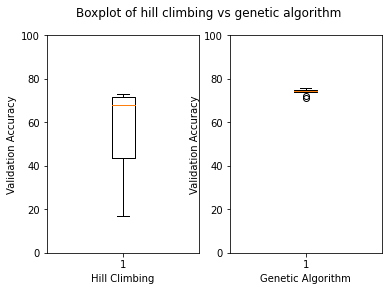

In [1]:
# code from cw1

import copy
import statistics
import matplotlib.pyplot as plt
 
initial_accs = [72, 73, 46, 43, 70, 17, 70, 66, 72, 18]
tmp_accs2 = [75, 75, 76, 76, 74, 75, 74, 71, 72, 74] 

print("Original: ")
# for i, f in enumerate(tmp_accs):
#     print("Round {}:\t{:.2f}".format(i + 1, f))
print("\nMean Acc:\t", end="")
print("{:.2f}".format(sum(initial_accs) / len(initial_accs)))
print("Median Acc:\t", end="")
tmp_accs_sort = copy.deepcopy(initial_accs)
tmp_accs_sort.sort()
print("{:.2f}".format(tmp_accs_sort[len(tmp_accs_sort) // 2]))
print("1st Quart Acc:\t", end="")
print("{:.2f}".format(tmp_accs_sort[len(tmp_accs_sort) // 4]))
print("3rd Quart Acc:\t", end="")
print("{:.2f}".format(tmp_accs_sort[len(tmp_accs_sort) // 4 * 3]))
print("Inter Quart:\t{}".format(tmp_accs_sort[len(tmp_accs_sort) // 4 * 3] - tmp_accs_sort[len(tmp_accs_sort) // 4]))
print("Standard dev:\t{}".format(statistics.stdev(initial_accs)))
 
print("\n\nMy Results: ")
# for i, f in enumerate(tmp_accs2):
#     print("Round {}:\t{:.2f}".format(i + 1, f))
print("\nMean Acc:\t", end="")
print("{:.2f}".format(sum(tmp_accs2) / len(tmp_accs2)))
print("Median Acc:\t", end="")
tmp_accs_sort_2 = copy.deepcopy(tmp_accs2)
tmp_accs_sort_2.sort()
print("{:.2f}".format(tmp_accs_sort_2[len(tmp_accs_sort_2) // 2]))
print("1st Quart Acc:\t", end="")
print("{:.2f}".format(tmp_accs_sort_2[len(tmp_accs_sort_2) // 4]))
print("3rd Quart Acc:\t", end="")
print("{:.2f}".format(tmp_accs_sort_2[len(tmp_accs_sort_2) // 4 * 3]))
print("Inter Quart:\t{}".format(tmp_accs_sort_2[len(tmp_accs_sort_2) // 4 * 3] - tmp_accs_sort_2[len(tmp_accs_sort_2) // 4]))
print("Standard dev:\t{}".format(statistics.stdev(tmp_accs2)))
 
fig = plt.figure()
fig.suptitle("Boxplot of hill climbing vs genetic algorithm")
ax = plt.subplot(1, 2, 1)
ax.boxplot(initial_accs)
plt.ylim(0, 100)
plt.xlabel("Hill Climbing")
plt.ylabel("Validation Accuracy")
 
ax = plt.subplot(1, 2, 2)
ax.boxplot(tmp_accs2)
plt.ylim(0, 100)
plt.xlabel("Genetic Algorithm")
plt.ylabel("Validation Accuracy")
plt.show()